# Discrete Hidden Markov Models

__Overview__: This lab is meant as an introduction to hidden Markov Models.

__Goals__: Students should:

1. Be able to implement the forward and backward pass for the discrete hidden markov model.
2. Be able to implement the viterbi algorithm for discrete hidden markov models.

In [1]:
from typing import Tuple

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
# Parameters for our distribution p(observation|latent). These will be long and
# randomized
np.random.seed(2)
obs_dim = 3
GAUSS_MEANS = [np.array([1.0, -1.0, 0.2]),
               np.array([0.6, 1.1, 1.0]),
               np.array([1.3, 1.0, 1.2])]
GAUSS_COVS = [np.eye(obs_dim) / 4]*3
PI = np.array([0.7, 0.2, 0.1])
A_MAT = np.array([[0.9, 0.0, 0.1], [0.0, 0.9, 0.1], [0.1, 0.3, 0.6]])

def generate_latent_and_observations(n_observtions: int) -> Tuple[np.ndarray, np.ndarray]:
    """Generate a sample set of observations along with the true latents.

    Args:
        n_observations: Number of observations to generate.

    Returns:
        Sequence of latent states and observations.
    """
    # Placeholders.
    latents = np.zeros((n_observtions + 1, len(PI)))
    observations = np.zeros((n_observtions, len(GAUSS_MEANS[0])))

    # Start with the initial latent state
    latents[0, np.random.choice(np.arange(len(PI)), p=PI)] = 1

    # Fill out the rest.
    for i in range(n_observtions):
        latents[i+1, np.random.choice(np.arange(len(PI)), p=A_MAT[np.argmax(latents[i])])] = 1
        cur_state = np.argmax(latents[i+1])
        observations[i] = np.random.multivariate_normal(GAUSS_MEANS[cur_state], GAUSS_COVS[cur_state])

    return latents, observations

def observation_probability(latent_index: int, observation: np.ndarray) -> float:
    """Given an observation and corresponding latent state, evaluate the likelihood.

    Args:
        latent_index: Index of latent state encoding.
        observation: Observation at current time step.

    Returns:
        Likelihood p(observation|latent).
    """
    # Let's keep things somewhat 'simple' by making our distribution a sum of Gaussians
    return stats.multivariate_normal.pdf(observation, mean = GAUSS_MEANS[latent_index], cov = GAUSS_COVS[latent_index])

# Generate the data for our study.
true_latents, observations = generate_latent_and_observations(1000)

## Emotion Study

Your friend in the sociology department is studying the effects of social media habits on emotions. They've run an experiment placing FMRI sensors on the brains of several volunteers as they scroll through the internet. The volunteers can be in one of three states: happy, angry, or neutral. They've used the following one-hot encoding:

$$
\pmb{z}_\text{happy} = \begin{bmatrix} 1 \\ 0 \\ 0 \end{bmatrix}, \ 
\pmb{z}_\text{angry} = \begin{bmatrix} 0 \\ 1 \\ 0 \end{bmatrix}, \
\pmb{z}_\text{neutral} = \begin{bmatrix} 0 \\ 0 \\ 1 \end{bmatrix}.
$$

Given that encoding, they also have a very good model for the probability of observing a specific FMRI scan $\pmb{x}_t$ given the state $\pmb{z}_t$. They have already done the favor of uploading it to your notebook as the function _observation_probability_. They also have a time series $\{\pmb{x}_1, \ldots \pmb{x}_T\}$ for a volunteer that spends a lot of time on social media. For this volunteer, they know that the transition matrix looks like:

$$
A = \begin{bmatrix} 0.9 & 0.0 & 0.1 \\ 0.0 & 0.9 & 0.1 \\ 0.1 & 0.3 & 0.6\end{bmatrix},
$$

and having observed the volunteer enter they have a pretty good guess at the initial state:

$$
\pi = \begin{bmatrix} 0.7 \\ 0.2 \\ 0.1 \end{bmatrix},
$$

They would like to know:

- __What is the most likely emotional state at each time step (i.e. max of  $p(z_t|x_{1:t})$ or $p(z_t|x_{1:T})$)?__
- __What is the most likely sequence of emotional states expressed by the volunteer?__

## Part I: Implementing the Viterbi Algorithm for a discrete Hidden Markov Model.

To answer your friend's questions, you will need to solve for the transition matrix governing the discrete HMM and calculate the most likely series of latent states. This will require:

1. Implementing the calculation for $\hat{\alpha}(\pmb{z}_t)$
2. Implementing the calculation for $\hat{\beta}(\pmb{z}_t)$
3. Implementing the calculation for $p(\pmb{z}_t | \pmb{x}_{1:t}), \ p(\pmb{z}_t | \pmb{x}_{1:T}), \ p(\pmb{z}_{1:T} | \pmb{x}_{1:T})$
4. Implementing the Viterbi algorithm.


In [3]:
# A useful helper function.
def one_hot_encode(state_index: int, dim_z: int) -> np.ndarray:
    """Return the one hot encoding for a latent state.

    Args:
        state_index: Latent state index. Counts from zero.
        dim_z: Number of latent states.

    Returns:
        One-hot encoding.
    """
    z_encode = np.zeros(dim_z)
    z_encode[state_index] = 1
    return z_encode


# Our class of interest.
class DiscreteHMM:
    """Class that implements a discrete HMM.
    
    Args:
        pi: Initial guess for the vector pi.
        transition_matrix: Initial guess for the transition matrix.
    """
    def __init__(self, pi: np.ndarray, transition_matrix: np.ndarray):
        """Initialize our class."""
        # Save the initial guess.
        self.pi = pi
        self.transition_matrix = transition_matrix

        # Some useful variables.
        self.dim_z = len(self.pi)

    def calc_alpha_hat(self, observations: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """Given the observations, calculate the normalized forward pass.

        Args:
            observations: Observations for each time step.

        Returns:
            Normalized forward pass for each time step and latent state and 
            normalization constants.
        """
        # Initialize a placeholder.
        alpha_hat = np.zeros((len(observations) + 1, self.dim_z))
        c_t = np.zeros((len(observations) + 1))

        # t=0 value. Consider c_0 = 1 for simplicity.
        alpha_hat[0] = self.pi
        c_t[0] = 1

        # Recurse forward.
        for t in range(1, len(alpha_hat)):
            for i in range(self.dim_z):
                for j in range(self.dim_z):
                    alpha_hat[t,i] += alpha_hat[t-1,j] * self.transition_matrix[j,i]
                alpha_hat[t,i] *= observation_probability(i, observations[t-1])
            # Don't forget to normalize alpha_hat!
            c_t[t] = np.sum(alpha_hat[t])
            alpha_hat[t] /= c_t[t]
            
        return alpha_hat, c_t

    def calc_beta_hat(self, observations: np.ndarray) -> np.ndarray:
        """Given the observations, calculate the normalized backward pass.

        Args:
            observations: Observations for each time step.

        Returns:
            Normalized backward pass for each time step.
        """
        # Initialize a placeholder.
        beta_hat = np.zeros((len(observations) + 1, self.dim_z))

        # Get the c_t values
        _, c_t = self.calc_alpha_hat(observations)

        # t=0 value.
        beta_hat[-1] = np.ones(self.dim_z, dtype=float)

        # Recurse backward.
        for t in range(len(beta_hat)-2, -1, -1):
            for i in range(self.dim_z):
                for j in range(self.dim_z):
                    beta_hat[t,i] += beta_hat[t+1,j] * observation_probability(j, observations[t]) * self.transition_matrix[i,j] 
            # Don't forget to normalize beta_hat!
            beta_hat[t] /= c_t[t+1]

        return beta_hat

    def p_zt_xt(self, observations: np.ndarray, alpha_hat: np.ndarray, 
                beta_hat: np.ndarray, c_t: np.ndarray):
        """Calculate p(z_t|x_{1:t}) for all t.

        Args:
            observations: Observations for each time step.
            alpha_hat: Normalized forward pass output.
            beta_hat: Normalized backward pass output.
            c_t: Normalization constants for forward and backward pass.

        Returns:
            Value of p(z_t|x_{1:t}) for each time step and latent state index.

        Notes:
            You may not need all of the inputs.
        """
        return alpha_hat
    
    def p_zt_xT(self, observations: np.ndarray, alpha_hat: np.ndarray, 
                beta_hat: np.ndarray, c_t: np.ndarray):
        """Calculate p(z_t|x_{1:T}) for all t.

        Args:
            observations: Observations for each time step.
            alpha_hat: Normalized forward pass output.
            beta_hat: Normalized backward pass output.
            c_t: Normalization constants for forward and backward pass.

        Returns:
            Value of p(z_t|x_{1:T}) for each time step and latent state index.

        Notes:
            You may not need all of the inputs.
        """
        gamma = alpha_hat * beta_hat             
        gamma /= np.sum(gamma, axis=1, keepdims=True)
        return gamma 

    def log_p_sequence_xt(self, observations: np.ndarray, latent_sequence: np.ndarray) -> float:
        """Log likelihood of the sequence given the data p(z_{1:T}|x_{1:T}).

        Args:
            observations: Observations for each time step.
            latent_sequence: Proposed latent sequence. Can be a probability
                distribution at each time step, in which case argmax will be taken
                to determine proposal.

        Returns:
            Log of the probability of the sequence given the data.
        """
        log_probability = 0
        sequence_indices = np.argmax(latent_sequence, axis=-1)

        # Log probability for first time step.
        log_probability += np.log(self.pi[sequence_indices[0]])

        # Log probability for remaining time steps.
        for t in range(len(observations)):
            z_prev = sequence_indices[t]
            z_curr = sequence_indices[t+1]
            log_probability += np.log(self.transition_matrix[z_prev, z_curr])
            log_probability += np.log(observation_probability(z_curr, observations[t]))
        return log_probability
        

    def viterbi_algorithm(self, observations: np.ndarray) -> np.ndarray:
        """Run the Viterbi algorithm on our dHMM observations.

        Args:
            observations: Observations for each time step.

        Returns:
            One-hot encoding of MAP sequence.
        """
        w_matrix = np.zeros((len(observations)+1, self.dim_z))
        m_matrix = np.zeros((len(observations), self.dim_z), dtype=int)

        # The first value of our weight matrix is just log of pi.
        w_matrix[0] = np.log(self.pi)

        # Fill out the weight matrix and the argmax matrix m.
        for t in range(len(observations)):
            for i in range(self.dim_z):
                # Let's find the best path to this state
                m_matrix[t,i] = np.argmax(w_matrix[t] + np.log(self.transition_matrix[:,i]))
                w_matrix[t+1,i] = w_matrix[t,m_matrix[t,i]] + np.log(self.transition_matrix[m_matrix[t,i],i]) + np.log(observation_probability(i, observations[t]))

        # Now we can work backwards to find the most likely path.
        map_z_path = np.ones(len(observations)+1, dtype=int) - 1 # Make sure you fill it all in!

        # MAP z_T.
        map_z_path[-1] = np.argmax(w_matrix[-1])

        # Remaining z_t.
        for t in range(len(observations)-1, -1, -1):
            map_z_path[t] = m_matrix[t, map_z_path[t+1]]
        # Turn it into our one-hot encoding
        map_z_encoded = np.zeros((len(observations) + 1, self.dim_z))
        for t in range(len(map_z_path)):
            map_z_encoded[t] = one_hot_encode(map_z_path[t], self.dim_z)

        return map_z_encoded

In [4]:
# Let's test all our functions.
dhmm_test = DiscreteHMM(pi = PI, transition_matrix = A_MAT)
test_observations = np.array(
    [[ 0.57912632, -1.75050344,  0.6467949 ],
     [ 1.27572702,  0.14610401,  0.2207697 ],
     [ 0.44103728, -0.75995758,  0.39349526]]
)

# Test our alpha_hat calculation.
aht, ctt = dhmm_test.calc_alpha_hat(test_observations)
np.testing.assert_almost_equal(
    aht,
    [[7.0000000e-01, 2.0000000e-01, 1.0000000e-01],
     [9.9999977e-01, 1.4661610e-07, 7.9086042e-08],
     [9.4237462e-01, 5.0723353e-08, 5.7625330e-02],
     [9.9993612e-01, 2.0604439e-05, 4.3274226e-05]]
)
np.testing.assert_almost_equal(
    ctt,
    [1.0, 0.0496036, 0.0300947, 0.1920015]
)

# Test the beta hat calculation.
bht = dhmm_test.calc_beta_hat(test_observations)
np.testing.assert_almost_equal(
    bht,
    [[1.4062500e+00, 1.2433363e-08, 1.5625005e-01],
     [1.0000002e+00, 7.1046726e-03, 1.5114756e-01],
     [1.0539542e+00, 1.1062680e-03, 1.1766142e-01],
     [1.0000000e+00, 1.0000000e+00, 1.0000000e+00]]
)

# Test the p(z_t|x_{1:t}) calculation.
pztt = dhmm_test.p_zt_xt(test_observations, aht, bht, ctt)
np.testing.assert_almost_equal(
    pztt,
    [[7.0000000e-01, 2.0000000e-01, 1.0000000e-01],
     [9.9999977e-01, 1.4661610e-07, 7.9086042e-08],
     [9.4237462e-01, 5.0723353e-08, 5.7625330e-02],
     [9.9993612e-01, 2.0604439e-05, 4.3274226e-05]]
)

# Test the p(z_t|x_{1:T}) calculation.
pzTt = dhmm_test.p_zt_xT(test_observations, aht, bht, ctt)
np.testing.assert_almost_equal(
    pzTt,
    [[9.8437499e-01, 2.4866725e-09, 1.5625005e-02],
     [9.9999999e-01, 1.0416594e-09, 1.1953662e-08],
     [9.9321972e-01, 5.6113622e-11, 6.7802781e-03],
     [9.9993612e-01, 2.0604439e-05, 4.3274226e-05]]
)

# Test the log p(z_{1:T}|x_{1:T}) calculation.
log_p_sxt = dhmm_test.log_p_sequence_xt(
    test_observations, pzTt
)
np.testing.assert_almost_equal(
    log_p_sxt, -8.1799327
)

# Test the viterbi algorithm.
z_map_t = dhmm_test.viterbi_algorithm(test_observations)
np.testing.assert_almost_equal(
    z_map_t,
    [[1., 0., 0.],
     [1., 0., 0.],
     [1., 0., 0.],
     [1., 0., 0.]]
)

# Test the viterbi algorithm on a tougher problem.
complex_observations = np.array(
    [[1.0, -1.0, 0.2],
     [0.6, 1.1, 1.0],
     [1.3, 1.0, 1.2]]
 )
z_map_t = dhmm_test.viterbi_algorithm(complex_observations)
np.testing.assert_almost_equal(
    z_map_t,
    [[1., 0., 0.],
     [1., 0., 0.],
     [0., 0., 1.],
     [0., 0., 1.]]
)

/var/folders/4_/d9fl5xf12xg1ctycd59mfsk80000gn/T/ipykernel_35611/3510116448.py:176: RuntimeWarning: divide by zero encountered in log
  m_matrix[t,i] = np.argmax(w_matrix[t] + np.log(self.transition_matrix[:,i]))


## Part II: Running our discrete HMM model on the observations.

You've implemented everything you need, now let's run on your friend's observations. Your friend wants to compare three different latent state estimates:
- Setting $z_t = \text{argmax}_k \ p(z_{t,k}|x_{1:t})$
- Setting $z_t = \text{argmax}_k \ p(z_{t,k}|x_{1:T})$
- Setting $z_t = \text{argmax}_{z_{1:T}} \ p(z_{1:t}|x_{1:T})$

/var/folders/4_/d9fl5xf12xg1ctycd59mfsk80000gn/T/ipykernel_35611/3510116448.py:176: RuntimeWarning: divide by zero encountered in log
  m_matrix[t,i] = np.argmax(w_matrix[t] + np.log(self.transition_matrix[:,i]))


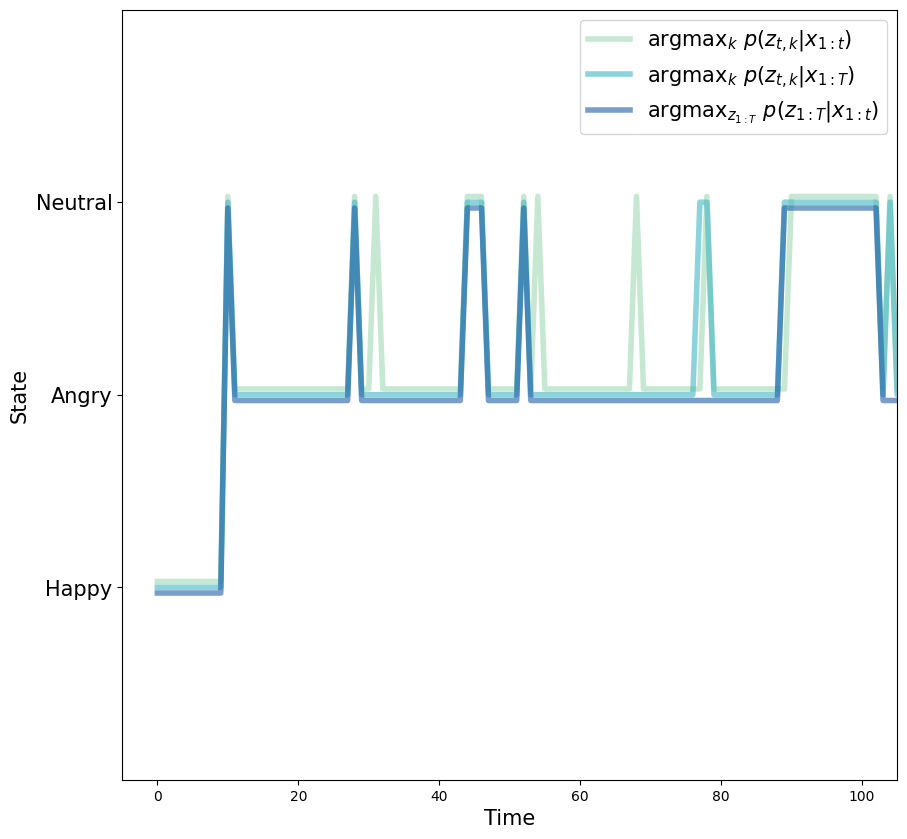

In [5]:
# Let's compare our three options.
dhmm = DiscreteHMM(pi = PI, transition_matrix = A_MAT)

# Start with the argmax of p(z_t|x_{1:t})
alpha_hat, c_t = dhmm.calc_alpha_hat(observations)
beta_hat = dhmm.calc_beta_hat(observations)
p_ztt = dhmm.p_zt_xt(observations, alpha_hat, beta_hat, c_t)
z_max_xt = np.argmax(p_ztt, axis=-1)

# Now the argmax of p(z_t|x_{1:T})
alpha_hat, c_t = dhmm.calc_alpha_hat(observations)
beta_hat = dhmm.calc_beta_hat(observations)
p_ztT = dhmm.p_zt_xT(observations, alpha_hat, beta_hat, c_t)
z_max_xT = np.argmax(p_ztT, axis=-1)

# Now the argmax of log p(z_{1:t}|x_{1:T})
z_oh_max_vt = dhmm.viterbi_algorithm(observations)
z_max_vt = np.argmax(z_oh_max_vt, axis=-1)

# Let's plot our three options
fig, ax = plt.subplots(1, 1, figsize=(10,10), dpi=100)
fontsize = 15

plt.plot(z_max_xt + 3e-2, lw=4, label=r'$\mathrm{argmax}_k \ p(z_{t,k}|x_{1:t})$', color='#a1dab4', alpha=0.6)
plt.plot(z_max_xT, lw=4, label=r'$\mathrm{argmax}_k \ p(z_{t,k}|x_{1:T})$', color='#41b6c4', alpha=0.6)
plt.plot(z_max_vt - 3e-2, lw=4, label=r'$\mathrm{argmax}_{z_{1:T}} \ p(z_{1:T}|x_{1:t})$', color='#225ea8', alpha=0.6)
plt.legend(fontsize=fontsize)
plt.ylim([-1,3])
plt.xlim([-5,105])
plt.xlabel('Time', fontsize=fontsize)
plt.ylabel('State', fontsize=fontsize)
plt.yticks([0,1,2], ['Happy','Angry','Neutral'], fontsize=fontsize)
plt.show()

Your friend is happy to see that all three estimates mostly agree, if a little unsettled by how much time the volunteer was angry. 

__Why does the volunteer spend so much time in the angry state? Make your argument using the transition matrix__

In [6]:
# Explain why the volunteer spends so much time angry using the transition matrix.
# Uses A_MAT (already defined in the notebook) and numpy (np already imported).

states = ["Happy", "Angry", "Neutral"]
A = A_MAT

# Compute stationary distribution (left eigenvector of A with eigenvalue 1)
w, v = np.linalg.eig(A.T)
idx = np.argmin(np.abs(w - 1.0))
stationary = np.real(v[:, idx])
stationary /= stationary.sum()

print("Transition matrix A:\n", A, "\n")
print("Key transition probabilities relevant to 'Angry':")
print(f" P(Angry -> Angry)   = {A[1,1]:.2f}  # very sticky")
print(f" P(Neutral -> Angry) = {A[2,1]:.2f}  # nontrivial inflow into Angry")
print(f" P(Happy -> Angry)   = {A[0,1]:.2f}  # essentially zero\n")

print("Stationary distribution (long-run fraction of time in each state):")
for s, p in zip(states, stationary):
    print(f" {s:6s}: {p:.3f}")

print("\nConclusion: Angry has a high self-transition (0.9) and receives additional inflow from Neutral (0.3).")
print("These facts make 'Angry' a persistent state, so the chain spends a large fraction of time in it.")

Transition matrix A:
 [[0.9 0.  0.1]
 [0.  0.9 0.1]
 [0.1 0.3 0.6]] 

Key transition probabilities relevant to 'Angry':
 P(Angry -> Angry)   = 0.90  # very sticky
 P(Neutral -> Angry) = 0.30  # nontrivial inflow into Angry
 P(Happy -> Angry)   = 0.00  # essentially zero

Stationary distribution (long-run fraction of time in each state):
 Happy : 0.200
 Angry : 0.600
 Neutral: 0.200

Conclusion: Angry has a high self-transition (0.9) and receives additional inflow from Neutral (0.3).
These facts make 'Angry' a persistent state, so the chain spends a large fraction of time in it.


In [ ]:
# TODO: Change this cell to markdown and write your answer to the question above.

raise ValueError('Answer the question.')

Your friend wants to compare the three possible sequences to find out which one is the most likely. Let's compare.

In [7]:
prob_z_xt = dhmm.log_p_sequence_xt(observations, p_ztt)
prob_z_xT = dhmm.log_p_sequence_xt(observations, p_ztT)
prob_z_vt = dhmm.log_p_sequence_xt(observations, z_oh_max_vt)

print(f'Log probability of argmax_k p(z_t,k|x_1:t): {prob_z_xt}')
print(f'Log probability of argmax_k p(z_t,k|x_1:T): {prob_z_xT}')
print(f'Log probability of argmax_(z_1:T) p(z_t|x_1:t): {prob_z_vt}')

Log probability of argmax_k p(z_t,k|x_1:t): -inf
Log probability of argmax_k p(z_t,k|x_1:T): -2525.4236434134336
Log probability of argmax_(z_1:T) p(z_t|x_1:t): -2514.121012618777


/var/folders/4_/d9fl5xf12xg1ctycd59mfsk80000gn/T/ipykernel_35611/3510116448.py:152: RuntimeWarning: divide by zero encountered in log
  log_probability += np.log(self.transition_matrix[z_prev, z_curr])


Your friend can see that the viterbi algorithm gives the most likely sequence, but they don't understand how it's possible that $\mathrm{argmax}_k \ p(z_{t,k}|x_{1:t})$ has zero probability. 

__How is it possible for $\mathrm{argmax}_k \ p(z_{t,k}|x_{1:t})$ to have zero likelihood? Is it possible for the results of the viterbi algorithm to have this issue?__

In [8]:
from IPython.display import Markdown, display

display(Markdown(
"""
Why argmax_k p(z_{t,k} | x_{1:t}) can have zero likelihood
- The per-time argmax picks the most likely state at each t independently and ignores transition constraints. Concatenating those per-time choices can produce a sequence that contains transitions with A[i,j] = 0, so the joint probability of the whole sequence is zero (because the chain assigns zero probability to that transition).
- Example: if A[0,1] = 0, and argmax at time t is state 0 while argmax at t+1 is state 1, then p(z_t=0, z_{t+1}=1 | x) = A[0,1] * ... = 0.

Is the Viterbi result subject to this problem?
- No (in the usual case). Viterbi maximizes the joint probability over entire sequences and enforces transition probabilities when building paths, so it will not return a path containing an impossible (zero-probability) transition unless every possible path has zero probability under the model.
- Edge cases: if the model itself makes every full path impossible (e.g., emissions zero for all states at some time) then Viterbi can also yield zero probability; numerical underflow can be avoided by running Viterbi in log-space (as in this notebook).
"""
))


Why argmax_k p(z_{t,k} | x_{1:t}) can have zero likelihood
- The per-time argmax picks the most likely state at each t independently and ignores transition constraints. Concatenating those per-time choices can produce a sequence that contains transitions with A[i,j] = 0, so the joint probability of the whole sequence is zero (because the chain assigns zero probability to that transition).
- Example: if A[0,1] = 0, and argmax at time t is state 0 while argmax at t+1 is state 1, then p(z_t=0, z_{t+1}=1 | x) = A[0,1] * ... = 0.

Is the Viterbi result subject to this problem?
- No (in the usual case). Viterbi maximizes the joint probability over entire sequences and enforces transition probabilities when building paths, so it will not return a path containing an impossible (zero-probability) transition unless every possible path has zero probability under the model.
- Edge cases: if the model itself makes every full path impossible (e.g., emissions zero for all states at some time) then Viterbi can also yield zero probability; numerical underflow can be avoided by running Viterbi in log-space (as in this notebook).


In [ ]:
# TODO: Change this cell to markdown and write your answer to the question above.

raise ValueError('Answer the question.')